In [1]:
using Pkg
Pkg.status()

      Status `~/Projects/GraphODEBenchmark/julia/Project.toml`
  [0c46a032] DifferentialEquations v6.17.1
  [7073ff75] IJulia v1.23.2
  [093fc24a] LightGraphs v1.3.5
  [6fafb56a] Memoization v0.1.12
  [91a5bcdd] Plots v1.16.5
  [37e2e3b7] ReverseDiff v1.9.0
  [47aef6b3] SimpleWeightedGraphs v1.1.1
  [90137ffa] StaticArrays v1.2.4
  [fce5fe82] Turing v0.16.3


In [2]:
using DelimitedFiles
using DifferentialEquations
using Turing
using StaticArrays
using Plots

In [3]:
const SL = readdlm("../graphs/ER-10-05.csv", ',', Float64) |> SMatrix{10,10}

10×10 SMatrix{10, 10, Float64, 100} with indices SOneTo(10)×SOneTo(10):
  2.21046    -0.64002   -0.430931  …   0.0       -0.173804  -0.9248
 -0.64002     2.61931    0.0           0.0        0.0       -0.832681
 -0.430931    0.0        1.7995        0.0       -0.528211   0.0
  0.0        -0.31156    0.0           0.0        0.0        0.0
 -0.0409037  -0.835045  -0.840359      0.0       -0.652083  -0.272671
  0.0         0.0        0.0       …  -0.983921   0.0        0.0
  0.0         0.0        0.0           0.0        0.0       -0.305935
  0.0         0.0        0.0           1.73753   -0.753613   0.0
 -0.173804    0.0       -0.528211     -0.753613   2.10771    0.0
 -0.9248     -0.832681   0.0           0.0        0.0        2.33609

In [4]:
function NetworkFKPP(du, u, p, t)
    du .= -p[1] * SL * u .+ p[2] .* u .* (1 .- u)
end

NetworkFKPP (generic function with 1 method)

In [5]:
u0 = zeros(10)
u0[5] = 0.1

p = [0.5, 1.5]

t_span = (0.0,10.0)

prob = ODEProblem(NetworkFKPP, u0, t_span, p)
sol = solve(prob, Tsit5(), saveat=1.0);

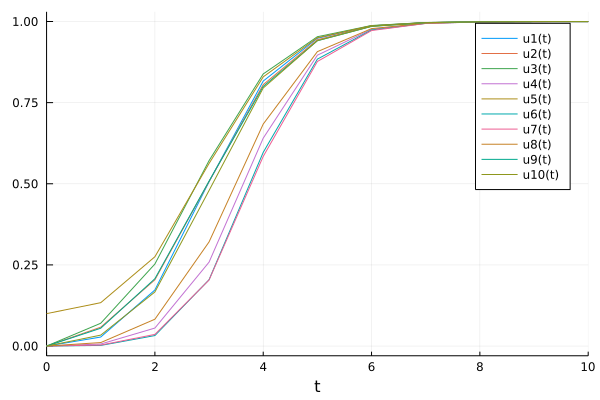

In [7]:
plot(sol)

In [35]:
@model function fit(data, prob)
    σ ~ InverseGamma(2, 3)

    k ~ truncated(Normal(1.0,2.0), 0, Inf)
    a ~ truncated(Normal(1.0,2.0), 0, Inf)

    problem = remake(prob, p=[k, a])
    predictions = solve(problem, Tsit5(), saveat=1.0)

    for i in 1:11
        data[:,i] .~ MvNormal(predictions[i], σ)
    end
end

fit (generic function with 1 method)

In [26]:
@model function fit1(data, prob)
    σ ~ InverseGamma(2, 3)

    k ~ truncated(Normal(1.0,2.0), 0, Inf)
    a ~ truncated(Normal(1.0,2.0), 0, Inf)

    problem = remake(prob, p=[k, a])
    predictions = solve(problem, Tsit5(), saveat=1.0)

    Turing.@addlogprob! sum(loglikelihood.(Normal.(predictions,σ), data)) 
end

fit1 (generic function with 1 method)

In [27]:
sum(loglikelihood.(Normal.(randn(2,2),2), rand(2,2)))

-6.874951164636105

In [28]:
m1 = fit1(Array(sol), prob);

In [31]:
chain = sample(m1, NUTS(0.65), 2_000)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/chaggar/.julia/packages/Turing/Fv8CB/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1:2000
Thinning interval = 1
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 2.35 seconds
Compute duration  = 2.35 seconds
parameters        = a, σ, k
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           σ    0.0275    0.0027     0.0001    0.0001   1802.7414    1.0008    ⋯
           k    0.5027    0.0231     0.0005    0.0006   1076.2774    0.9995    ⋯
           a    1.4998    0.0103     0.0002    0.0003   1193.3417    1.0005    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     5

In [36]:
m = fit(Array(sol),prob);

In [38]:
@time chain = sample(m, NUTS(0.65), 2_000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/pavanchaggar/.julia/packages/Turing/Fv8CB/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.188129 seconds (3.37 M allocations: 625.382 MiB, 22.52% gc time)


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1:2000
Thinning interval = 1
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 1.18 seconds
Compute duration  = 1.18 seconds
parameters        = a, σ, k
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           σ    0.0274    0.0026     0.0001    0.0001   2059.5899    0.9995    ⋯
           k    0.5016    0.0224     0.0005    0.0006   1277.0409    0.9998    ⋯
           a    1.5000    0.0098     0.0002    0.0002   1525.3398    1.0005    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     5

In [45]:
using ReverseDiff, Memoization
Turing.setadbackend(:reversediff)
Turing.setrdcache(true)
Turing.emptyrdcache()

In [46]:
@time chain = sample(m, NUTS(0.65), 2_000)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/pavanchaggar/.julia/packages/Turing/Fv8CB/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/pavanchaggar/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:   2%|█                                        |  ETA: 0:04:08┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/pavanchaggar/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  16%|██████▌                                  |  ETA: 0:02:15┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/pavanchaggar/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  22%|████████▉           

 93.747653 seconds (2.30 M allocations: 189.783 MiB, 0.04% gc time)


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1:2000
Thinning interval = 1
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 93.74 seconds
Compute duration  = 93.74 seconds
parameters        = a, σ, k
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           σ    0.0274    0.0028     0.0001    0.0001   1427.9940    0.9995    ⋯
           k    0.5009    0.0239     0.0005    0.0005   1230.4412    1.0013    ⋯
           a    1.4998    0.0101     0.0002    0.0002   1447.8766    1.0001    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%    